In [1]:
from sklearn.linear_model import LogisticRegression as lr

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
import polars as pl

### ***Data Preparation***

In [2]:
from functions import *
import math
import numpy as np
import pandas as pd
# import scipy.stats as stats
import statsmodels.api as sm

import matplotlib.pyplot as plt


import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)

In [3]:
payment_order_raw = pl.read_csv('./order records/payment_37_38.csv')
payment_order = payment_order_raw.select(['uname','paytime','product_id_2',
                                          'order_bn','sales_amount','margin','average_cost_freight','createway','shop_type','nums'])
payment_order_agg = payment_order.groupby("order_bn").agg(
        [   pl.first("uname"),
            pl.sum("sales_amount"),
             pl.sum("nums"),
            pl.sum("average_cost_freight"),
            pl.first("paytime"),
        ])
    

In [4]:
ship_order_raw = pl.read_csv('./order records/ship_order_37_38.csv')
ship_order = ship_order_raw.select(['order_bn','logi_no',
                                    'split_time','ship_time','product_id','nums','sales_amount','margin','average_cost_freight'])
ship_order_agg = ship_order.groupby("order_bn").agg(
        [   
            pl.sum("sales_amount"),
            pl.sum("average_cost_freight"),
            pl.min("split_time"),
            pl.min("ship_time"),
        ]
    )

In [5]:
return_order_raw = pl.read_csv('./order records/return_order_37_38.csv')
return_order = return_order_raw.select(['order_bn','product_id','tmall_id',
                                      'refund_apply_create_time','aftersale_request_num','refund_amount','t_sent','ship_status','return_type','logi_no','logi_name','sales_amount','purchase_num','delivery_warehouse'])

return_order_agg = return_order.groupby("order_bn").agg(
        [   
            pl.sum("refund_amount"),
            pl.min("refund_apply_create_time"),
            pl.min("t_sent"),
        ]
    )

In [6]:
## 计算每笔订单的退货情况以及时效情况
order_ttl_agg = payment_order_agg.join(ship_order_agg, on = "order_bn", how = "left")
order_ttl_agg = order_ttl_agg.join(return_order_agg, on = "order_bn", how = "left")

In [7]:
order_ttl_agg

order_bn,uname,sales_amount,nums,average_cost_freight,paytime,sales_amount_right,average_cost_freight_right,split_time,ship_time,refund_amount,refund_apply_create_time,t_sent
i64,str,f64,i64,f64,str,f64,f64,str,str,f64,str,str
1624090323652444160,"""jianchen8601""",579.9,1,0.0,"""2021-03-07 14:...",579.9,0.0,"""2021-03-07 14:...","""2021-03-07 18:...",579.9,"""2021-03-12 11:...","""2021-03-13 13:..."
1623474397077012480,"""猪猪爱虎虎2009""",99.89,1,0.0,"""2021-03-07 14:...",99.89,0.0,"""2021-03-07 14:...","""2021-03-07 19:...",null,null,null
1622816928183705600,"""fanzishuo27""",2549.9,1,0.0,"""2021-03-07 16:...",2549.9,0.0,"""2021-03-07 18:...","""2021-03-08 11:...",null,null,null
1625299203884867584,"""我爱他们爱我的人""",99.9,1,0.0,"""2021-03-07 20:...",99.9,0.0,"""2021-03-07 20:...","""2021-03-08 10:...",null,null,null
1625310759972126720,"""ninghengyan""",39.9,1,0.0,"""2021-03-07 20:...",39.9,0.0,"""2021-03-07 20:...","""2021-03-08 14:...",null,null,null
1625846473494609920,"""tb431514158""",19.9,1,6.0,"""2021-03-08 10:...",19.9,6.0,"""2021-03-08 10:...","""2021-03-08 16:...",null,null,null
1625021568093331456,"""马海英0130""",69.9,1,0.0,"""2021-03-08 10:...",69.9,0.0,"""2021-03-08 10:...","""2021-03-08 21:...",null,null,null
1626798891628871680,"""杜宾的春天""",559.697,4,0.0,"""2021-03-08 11:...",559.695,0.0,"""2021-03-08 11:...","""2021-03-08 17:...",null,null,null
1628232517211619328,"""tb038154694""",199.9,1,0.0,"""2021-03-08 21:...",199.9,0.0,"""2021-03-08 21:...","""2021-03-09 13:...",null,null,null


In [8]:
order_ttl_agg = order_ttl_agg.with_columns(
   [ (pl.col("paytime").str.strptime(pl.Datetime, strict=False)),
     (pl.col("refund_apply_create_time").str.strptime(pl.Datetime, strict=False)),
     (pl.col("split_time").str.strptime(pl.Datetime, strict=False)),
     (pl.col("ship_time").str.strptime(pl.Datetime, strict=False)),]) 

In [9]:
order_ttl_agg = order_ttl_agg.with_columns([(pl.col("refund_apply_create_time") - pl.col("paytime")).alias("return_leadtime"),
                            (pl.col("ship_time") - pl.col("paytime")).alias("ship_leadtime")] )

In [10]:
order_ttl_agg_return = order_ttl_agg.filter(~pl.col("t_sent").is_null())
order_ttl_agg_return =  order_ttl_agg_return.with_column((pl.when(pl.col("ship_leadtime").is_null()).then(pl.col("return_leadtime")).otherwise(pl.col("ship_leadtime"))).alias("ship_leadtime")).with_columns(
                             [(pl.col("return_leadtime").apply(lambda x :  x.days*24+x.seconds/3600 )).alias("return_leadtime"),(pl.col("ship_leadtime").apply(lambda x :  x.days*24+x.seconds/3600 )).alias("ship_leadtime")])
order_ttl_agg_return

order_bn,uname,sales_amount,nums,average_cost_freight,paytime,sales_amount_right,average_cost_freight_right,split_time,ship_time,refund_amount,refund_apply_create_time,t_sent,return_leadtime,ship_leadtime
i64,str,f64,i64,f64,datetime[μs],f64,f64,datetime[μs],datetime[μs],f64,datetime[μs],str,f64,f64
1624090323652444160,"""jianchen8601""",579.9,1,0.0,2021-03-07 14:15:12,579.9,0.0,2021-03-07 14:15:16,2021-03-07 18:00:22,579.9,2021-03-12 11:11:23,"""2021-03-13 13:...",116.936389,3.752778
1627745652629651456,"""伯爵与妖精的旋律""",289.7,3,0.0,2021-03-08 23:59:40,289.7,0.0,2021-03-08 23:59:44,2021-03-09 13:17:18,20.0,2021-03-19 10:01:57,"""2021-03-19 10:...",250.038056,13.293889
1624392615685431672,"""2438728893trhy...",79.9,1,2.0,2021-03-07 15:49:55,79.9,2.0,2021-03-07 15:49:59,2021-03-08 10:14:56,79.9,2021-03-10 09:35:57,"""2021-03-10 22:...",65.767222,18.416944
1625250745208603000,"""一二三四五meng""",59.9,1,0.0,2021-03-07 23:32:20,59.9,0.0,2021-03-07 23:32:23,2021-03-08 17:58:52,59.9,2021-03-09 21:55:36,"""2021-03-10 18:...",46.387778,18.442222
1624597056450756984,"""tb2421957822""",579.8,2,0.0,2021-03-08 08:09:51,185.617,0.0,2021-03-08 08:12:19,2021-03-08 11:25:04,395.77,2021-03-08 08:10:42,"""2021-03-08 08:...",0.014167,3.253611
1259414040330117496,"""爱我就不要离开我""",589.3,7,0.0,2021-03-08 10:20:32,null,null,null,null,685.24,2021-03-08 10:21:09,"""2021-03-08 10:...",0.010278,0.010278
1625903928040923512,"""wjm锦棉""",99.9,1,0.0,2021-03-08 15:20:43,null,null,null,null,99.9,2021-03-08 15:45:08,"""2021-03-08 15:...",0.406944,0.406944
1628221611503108472,"""阿扯扯23""",99.8,2,0.0,2021-03-08 18:43:39,99.8,0.0,2021-03-08 18:43:42,2021-03-08 21:03:52,19.16,2021-03-13 09:45:06,"""2021-03-14 13:...",111.024167,2.336944
1624669671712400112,"""想5寶貝""",209.598,4,0.0,2021-03-07 17:09:30,190.604,0.0,2021-03-08 18:00:48,2021-03-08 20:08:25,18.99,2021-03-07 18:41:41,"""2021-03-07 18:...",1.536389,26.981944


In [11]:
order_ttl_agg_ship = order_ttl_agg.filter(~pl.col("ship_leadtime").is_null())
order_ttl_agg_ship =  order_ttl_agg_ship.with_column((pl.col("ship_leadtime").apply(lambda x :  x.days*24+x.seconds/3600 )).alias("ship_leadtime"))
## 没有退款记录的order return_leadtime ==> 0
order_ttl_agg_ship =  order_ttl_agg_ship.with_column((pl.col("return_leadtime").fill_null(pl.lit(0))).cast(pl.Duration()))
order_ttl_agg_ship =  order_ttl_agg_ship.with_column((pl.col("return_leadtime").apply(lambda x :  x.days*24+x.seconds/3600 )).alias("return_leadtime"))                                                      
order_ttl_agg_ship

order_bn,uname,sales_amount,nums,average_cost_freight,paytime,sales_amount_right,average_cost_freight_right,split_time,ship_time,refund_amount,refund_apply_create_time,t_sent,return_leadtime,ship_leadtime
i64,str,f64,i64,f64,datetime[μs],f64,f64,datetime[μs],datetime[μs],f64,datetime[μs],str,f64,f64
1624090323652444160,"""jianchen8601""",579.9,1,0.0,2021-03-07 14:15:12,579.9,0.0,2021-03-07 14:15:16,2021-03-07 18:00:22,579.9,2021-03-12 11:11:23,"""2021-03-13 13:...",116.936389,3.752778
1623474397077012480,"""猪猪爱虎虎2009""",99.89,1,0.0,2021-03-07 14:35:34,99.89,0.0,2021-03-07 14:35:37,2021-03-07 19:35:46,null,null,null,0.0,5.003333
1622816928183705600,"""fanzishuo27""",2549.9,1,0.0,2021-03-07 16:22:04,2549.9,0.0,2021-03-07 18:01:53,2021-03-08 11:04:12,null,null,null,0.0,18.702222
1625299203884867584,"""我爱他们爱我的人""",99.9,1,0.0,2021-03-07 20:12:55,99.9,0.0,2021-03-07 20:12:58,2021-03-08 10:59:58,null,null,null,0.0,14.784167
1625310759972126720,"""ninghengyan""",39.9,1,0.0,2021-03-07 20:16:00,39.9,0.0,2021-03-07 20:16:04,2021-03-08 14:15:01,null,null,null,0.0,17.983611
1625846473494609920,"""tb431514158""",19.9,1,6.0,2021-03-08 10:10:51,19.9,6.0,2021-03-08 10:10:54,2021-03-08 16:26:23,null,null,null,0.0,6.258889
1625021568093331456,"""马海英0130""",69.9,1,0.0,2021-03-08 10:57:17,69.9,0.0,2021-03-08 10:57:20,2021-03-08 21:37:13,null,null,null,0.0,10.665556
1626798891628871680,"""杜宾的春天""",559.697,4,0.0,2021-03-08 11:19:26,559.695,0.0,2021-03-08 11:19:29,2021-03-08 17:23:12,null,null,null,0.0,6.062778
1628232517211619328,"""tb038154694""",199.9,1,0.0,2021-03-08 21:52:36,199.9,0.0,2021-03-08 21:52:39,2021-03-09 13:53:52,null,null,null,0.0,16.021111


E:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


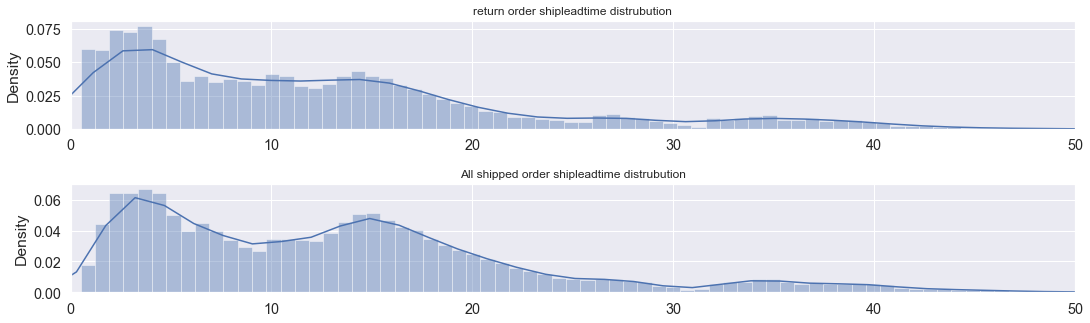

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
fig ,ax= plt.subplots(2,1,figsize =(18,5))
sns.set_theme(style="darkgrid")
sns.distplot(order_ttl_agg_return[:,['ship_leadtime']].filter(pl.col('ship_leadtime')>0.5),kde = True,bins= 400,ax=ax[0])
sns.distplot(order_ttl_agg_ship[:,['ship_leadtime']].filter(pl.col('ship_leadtime')>0.5),kde = True,bins= 400,ax=ax[1])
ax[0].set_xlim(0,50)
ax[0].set_title("return order shipleadtime distrubution")
ax[1].set_xlim(0,50)
ax[1].set_title("All shipped order shipleadtime distrubution")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)


对比退货订单的发货时效分布与全量发货订单的发货时效订单分布的差异

In [13]:
## 生成bins
breaks = list(range(0,51))

## 获取每个leadtime bin区间的退款率
ship_leadtime_bins = pl.cut(order_ttl_agg_ship.select(pl.col("ship_leadtime")).get_columns()[0], breaks).groupby(
                                    'category').count().sort('category').rename(
                                    {"category": "ship_leadtime","count": "ship_cnt"}).with_column(pl.col('ship_leadtime').cast(pl.Utf8))
return_leadtime_bins = pl.cut(order_ttl_agg_return.select(pl.col("ship_leadtime")).get_columns()[0], breaks).groupby('category').count().sort('category').rename({"category": "ship_leadtime","count": "rerurn_cnt"}).with_column(pl.col('ship_leadtime').cast(pl.Utf8))
leadtime_bins = ship_leadtime_bins.join(return_leadtime_bins,on = "ship_leadtime",how = "inner")
leadtime_bins = leadtime_bins.with_column((pl.col("rerurn_cnt")/pl.col("ship_cnt")).alias("return_rate"))

Text(0.5, 1.0, 'Relation between leadtime and return')

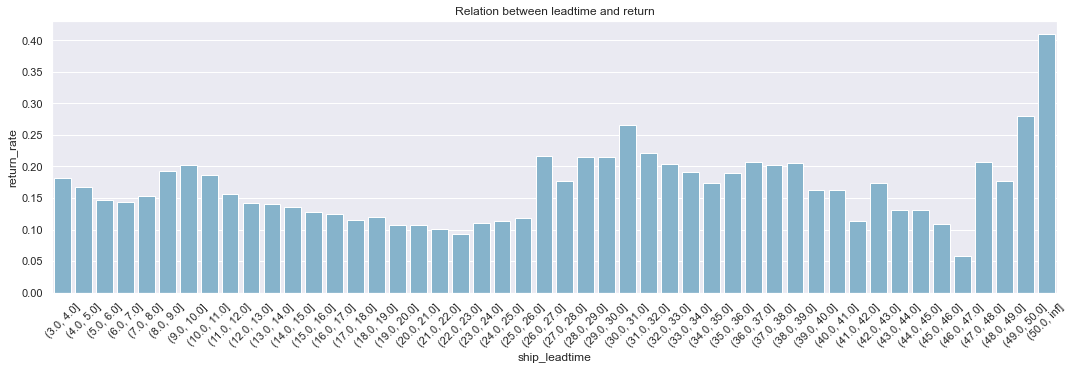

In [14]:
##调色盘选颜色
diverging_colors = sns.color_palette("RdBu", 10)

fig ,ax= plt.subplots(1,1,figsize =(18,5))

## 不考虑3小时内发货以及退款的关系
sns.barplot(data = leadtime_bins[3:,:].to_pandas(), x= "ship_leadtime", y= "return_rate",ax =ax,color=diverging_colors[7])
for item in ax.get_xticklabels():
    item.set_rotation(45)
ax.set_title("Relation between leadtime and return")


在考虑周期性的情况下随着发货时间延长退款数量明显出现下降趋势，后续添加当天hour作为变量

### ***变量创建***

消费者历史购买信息：1.历史一年购买频次 2.历史一年购买金额 3.最近一次消费时间

In [15]:
import os
file_path = './sample characteristics/'
dir_file  = os.listdir(file_path)
sample_variable = pl.read_csv(file_path+dir_file[0])
for i in range(1,len(dir_file)):
    sample_variable_1 = pl.read_csv(file_path+dir_file[i])
    sample_variable = sample_variable.join(sample_variable_1, on="uname", how="left")
sample_variable = sample_variable.rename({"sales_amount":"spend_one_year","paytime":"paytime_recent"})

消费者当期消费特征：1.消费者购买时间 2.消费者购买产品类型

In [16]:
order_ttl_agg_ship = order_ttl_agg_ship.with_column(pl.col("paytime").apply(lambda x: x.hour).alias("pay_hour"))

### ***Treatment and comparasion 划分 & propensity score calculate***

In [90]:
##剔除3小时内退款的订单
order_ttl_agg_ship_filter = order_ttl_agg_ship.filter(((pl.col("return_leadtime")>3)|(pl.col("return_leadtime")==0))&(pl.col("ship_leadtime")>8))

In [91]:
order_ttl_agg_ship_filter = order_ttl_agg_ship_filter.join(sample_variable,on = 'uname',how = 'left')
order_ttl_agg_ship_filter = order_ttl_agg_ship_filter.with_columns([pl.col("spend_one_year").fill_null(pl.lit(0)),pl.col("cnt").fill_null(pl.lit(0)),
                                                                   (pl.when(pl.col("refund_apply_create_time").is_null()).then(0).otherwise(1)).alias("label"),
                                                                   (pl.when(pl.col("ship_leadtime")>12).then(1).otherwise(0)).alias("treatment")])
order_ttl_agg_ship_filter

order_bn,uname,sales_amount,nums,average_cost_freight,paytime,sales_amount_right,average_cost_freight_right,split_time,ship_time,refund_amount,refund_apply_create_time,t_sent,return_leadtime,ship_leadtime,pay_hour,spend_one_year,cnt,paytime_recent,label,treatment
i64,str,f64,i64,f64,datetime[μs],f64,f64,datetime[μs],datetime[μs],f64,datetime[μs],str,f64,f64,i64,f64,i64,str,i32,i32
1622816928183705600,"""fanzishuo27""",2549.9,1,0.0,2021-03-07 16:22:04,2549.9,0.0,2021-03-07 18:01:53,2021-03-08 11:04:12,null,null,null,0.0,18.702222,16,2729.9,1,"""2021-01-25 09:...",0,1
1625299203884867584,"""我爱他们爱我的人""",99.9,1,0.0,2021-03-07 20:12:55,99.9,0.0,2021-03-07 20:12:58,2021-03-08 10:59:58,null,null,null,0.0,14.784167,20,0.0,0,null,0,1
1625310759972126720,"""ninghengyan""",39.9,1,0.0,2021-03-07 20:16:00,39.9,0.0,2021-03-07 20:16:04,2021-03-08 14:15:01,null,null,null,0.0,17.983611,20,149.9,1,"""2020-06-01 08:...",0,1
1625021568093331456,"""马海英0130""",69.9,1,0.0,2021-03-08 10:57:17,69.9,0.0,2021-03-08 10:57:20,2021-03-08 21:37:13,null,null,null,0.0,10.665556,10,0.0,0,null,0,0
1628232517211619328,"""tb038154694""",199.9,1,0.0,2021-03-08 21:52:36,199.9,0.0,2021-03-08 21:52:39,2021-03-09 13:53:52,null,null,null,0.0,16.021111,21,0.0,0,null,0,1
1627745652629651456,"""伯爵与妖精的旋律""",289.7,3,0.0,2021-03-08 23:59:40,289.7,0.0,2021-03-08 23:59:44,2021-03-09 13:17:18,20.0,2021-03-19 10:01:57,"""2021-03-19 10:...",250.038056,13.293889,23,764.69,2,"""2020-11-11 22:...",1,1
1624392615685431672,"""2438728893trhy...",79.9,1,2.0,2021-03-07 15:49:55,79.9,2.0,2021-03-07 15:49:59,2021-03-08 10:14:56,79.9,2021-03-10 09:35:57,"""2021-03-10 22:...",65.767222,18.416944,15,0.0,0,null,1,1
1625250745208603000,"""一二三四五meng""",59.9,1,0.0,2021-03-07 23:32:20,59.9,0.0,2021-03-07 23:32:23,2021-03-08 17:58:52,59.9,2021-03-09 21:55:36,"""2021-03-10 18:...",46.387778,18.442222,23,0.0,0,null,1,1
1625689226179142008,"""sayingyuke""",105.0,1,0.0,2021-03-08 00:13:18,105.0,0.0,2021-03-08 00:13:22,2021-03-08 14:41:27,null,null,null,0.0,14.469167,0,0.0,0,null,0,1


In [92]:
# Design pipeline to build the treatment estimator
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', lr())
])
treatment = order_ttl_agg_ship_filter.select(pl.col("treatment")).get_columns()[0]
X_variable = order_ttl_agg_ship_filter.select(pl.col(["pay_hour","nums"])).to_pandas()
pipe.fit(X_variable, treatment)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_classifier', LogisticRegression())])

In [93]:
predictions = pipe.predict_proba(X_variable)
predictions_binary = pipe.predict(X_variable)

In [94]:
print('Accuracy: {:.4f}\n'.format(metrics.accuracy_score(treatment, predictions_binary)))
print('Confusion matrix:\n{}\n'.format(metrics.confusion_matrix(treatment, predictions_binary)))
print('F1 score is: {:.4f}'.format(metrics.f1_score(treatment, predictions_binary)))

Accuracy: 0.7991

Confusion matrix:
[[   43 11070]
 [   86 44322]]

F1 score is: 0.8882


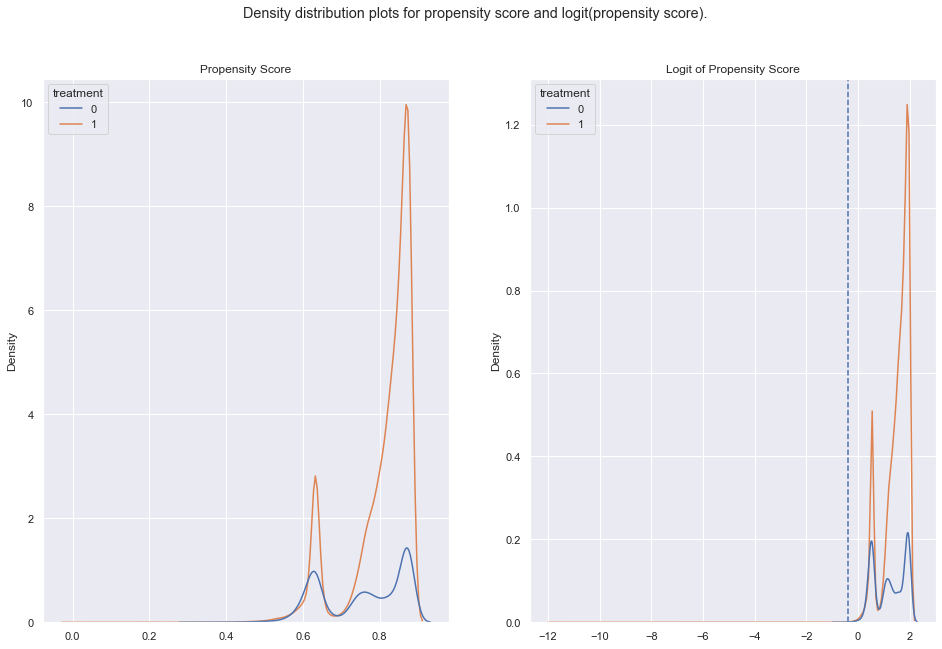

In [95]:
import numpy as np
predictions_logit = np.array([logit(xi) for xi in predictions[:,1]])
# Density distribution of propensity score (logic) broken down by treatment status
fig, ax = plt.subplots(1,2)
fig.suptitle('Density distribution plots for propensity score and logit(propensity score).')
sns.kdeplot(x = predictions[:,1], hue = treatment , ax = ax[0])
ax[0].set_title('Propensity Score')
sns.kdeplot(x = predictions_logit, hue = treatment , ax = ax[1])
ax[1].axvline(-0.4, ls='--')
ax[1].set_title('Logit of Propensity Score')
plt.show()

In [96]:
# Currently this does not affect the results as all observations fall within this range.
common_support = (predictions_logit > -10) & (predictions_logit < 10)

In [97]:
df_data = order_ttl_agg_ship_filter.select(pl.col(["pay_hour","nums","treatment"])).to_pandas()
y = order_ttl_agg_ship_filter.select(pl.col("label")).get_columns()[0].to_pandas()

In [98]:
df_data.loc[:,'propensity_score'] = predictions[:,1]
df_data.loc[:,'propensity_score_logit'] = predictions_logit
df_data.loc[:,'outcome'] = y

X_variable.loc[:,'propensity_score'] = predictions[:,1]
X_variable.loc[:,'propensity_score_logit'] = predictions_logit
X_variable.loc[:,'outcome'] = y
X_variable.loc[:,'treatment'] = df_data.treatment

### ***Matching Implementation***
Use Nearerst Neighbors to identify matching candidates. Then perform 1-to-1 matching by isolating/identifying groups of (T=1,T=0).
- Caliper: 25% of standart deviation of logit(propensity score)

In [99]:
caliper = np.std(df_data.propensity_score) * 0.25

print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))

df_data = X_variable

knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
knn.fit(df_data[['propensity_score_logit']].to_numpy())


Caliper (radius) is: 0.0226



NearestNeighbors(n_neighbors=10, radius=0.022619581883716093)

In [100]:
# Common support distances and indexes
distances , indexes = knn.kneighbors(
    df_data[['propensity_score_logit']].to_numpy(), \
    n_neighbors=10)

In [101]:
print('For item 0, the 4 closest distances are (first item is self):')
for ds in distances[0,0:4]:
    print('Element distance: {:4f}'.format(ds))
print('...')

For item 0, the 4 closest distances are (first item is self):
Element distance: 0.000000
Element distance: 0.000000
Element distance: 0.000000
Element distance: 0.000000
...


In [102]:
print('For item 0, the 4 closest indexes are (first item is self):')
for idx in indexes[0,0:4]:
    print('Element index: {}'.format(idx))
print('...')

For item 0, the 4 closest indexes are (first item is self):
Element index: 66
Element index: 263
Element index: 126
Element index: 220
...


In [103]:
def perfom_matching_v2(row, indexes, df_data):
    current_index = int(row['index']) # Obtain value from index-named column, not the actual DF index.
    prop_score_logit = row['propensity_score_logit']
    for idx in indexes[current_index,:]:
        if (current_index != idx) and (row.treatment == 1) and (df_data.loc[idx].treatment == 0):
            return int(idx)
         
df_data['matched_element'] = df_data.reset_index().apply(perfom_matching_v2, axis = 1, args = (indexes, df_data))

In [104]:
treated_with_match = ~df_data.matched_element.isna()

In [105]:
treated_matched_data = df_data[treated_with_match][df_data.columns]
treated_matched_data.head(3)

,pay_hour,nums,propensity_score,propensity_score_logit,outcome,treatment,matched_element
0,16,1,0.827725,1.569588,0,1,20.0
1,20,1,0.861240,1.825630,0,1,152.0
2,20,1,0.861240,1.825630,0,1,152.0


In [106]:
def obtain_match_details(row, all_data, attribute):
    return all_data.loc[row.matched_element][attribute]

untreated_matched_data = pd.DataFrame(data = treated_matched_data.matched_element)

attributes = ["pay_hour","nums",'propensity_score', 'propensity_score_logit', 'outcome', 'treatment']
for attr in attributes:
    untreated_matched_data[attr] = untreated_matched_data.apply(obtain_match_details, axis = 1, all_data = df_data, attribute = attr)
    
untreated_matched_data = untreated_matched_data.set_index('matched_element')
untreated_matched_data.head(3)

,pay_hour,nums,propensity_score,propensity_score_logit,outcome,treatment
matched_element,,,,,,
20.0,16.0,1.0,0.827725,1.569588,0.0,0.0
152.0,20.0,1.0,0.861240,1.825630,0.0,0.0
152.0,20.0,1.0,0.861240,1.825630,0.0,0.0


In [107]:
untreated_matched_data.shape

(33712, 6)

In [108]:
all_mached_data = pd.concat([treated_matched_data, untreated_matched_data])

In [109]:
all_mached_data

,pay_hour,nums,propensity_score,propensity_score_logit,outcome,treatment,matched_element
0.0,16.0,1.0,0.827725,1.569588,0.0,1.0,20.0
1.0,20.0,1.0,0.861240,1.825630,0.0,1.0,152.0
2.0,20.0,1.0,0.861240,1.825630,0.0,1.0,152.0
4.0,21.0,1.0,0.868715,1.889640,0.0,1.0,246.0
5.0,23.0,3.0,0.867332,1.877572,1.0,1.0,807.0
...,...,...,...,...,...,...,...
931.0,0.0,3.0,0.599967,0.405329,0.0,0.0,NaN
344.0,0.0,2.0,0.616655,0.475374,0.0,0.0,NaN
33.0,22.0,1.0,0.875844,1.953651,1.0,0.0,NaN
109.0,15.0,1.0,0.818405,1.505577,0.0,0.0,NaN


### ***Matching Review***

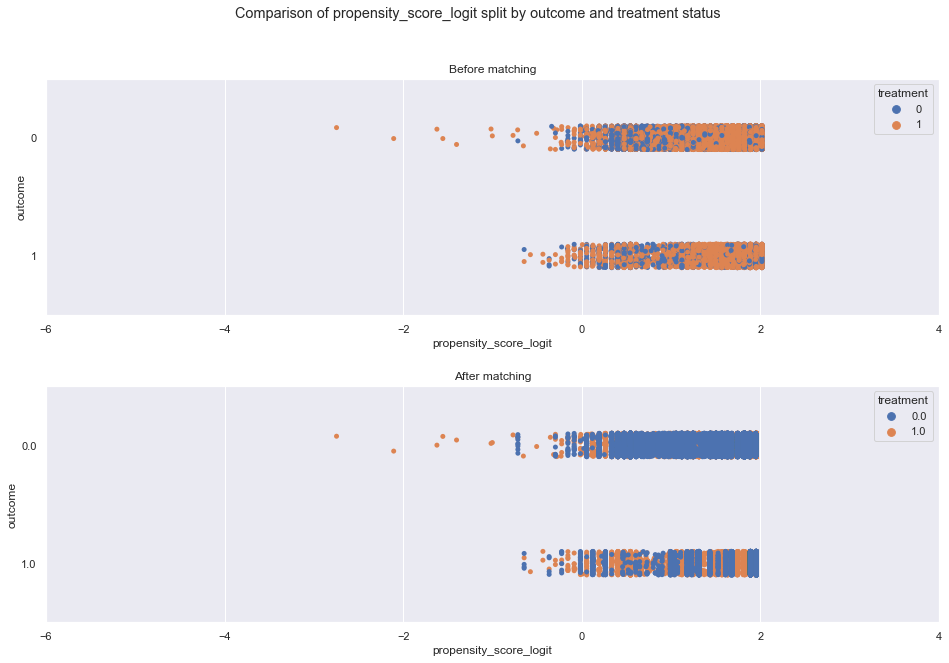

In [110]:
fig, ax = plt.subplots(2,1)
fig.suptitle('Comparison of {} split by outcome and treatment status'.format('propensity_score_logit'))
sns.stripplot(data = df_data, y = 'outcome', x = 'propensity_score_logit', hue = 'treatment', orient = 'h', ax = ax[0]).set(title = 'Before matching', xlim=(-6, 4))
sns.stripplot(data = all_mached_data, y = 'outcome', x = 'propensity_score_logit', hue = 'treatment', ax = ax[1] , orient = 'h').set(title = 'After matching', xlim=(-6, 4))
plt.subplots_adjust(hspace = 0.3)
plt.show()
fig.savefig("jitter_plot.png")

In [111]:
data = []
cols = ["pay_hour","nums"]
# cols = ['Age','SibSp','Parch','Fare','sex_female','sex_male','embarked_C','embarked_Q','embarked_S']
for cl in cols:
    data.append([cl,'before', cohenD(df_data,cl)])
    data.append([cl,'after', cohenD(all_mached_data,cl)])

In [112]:
res = pd.DataFrame(data, columns=['variable','matching','effect_size'])

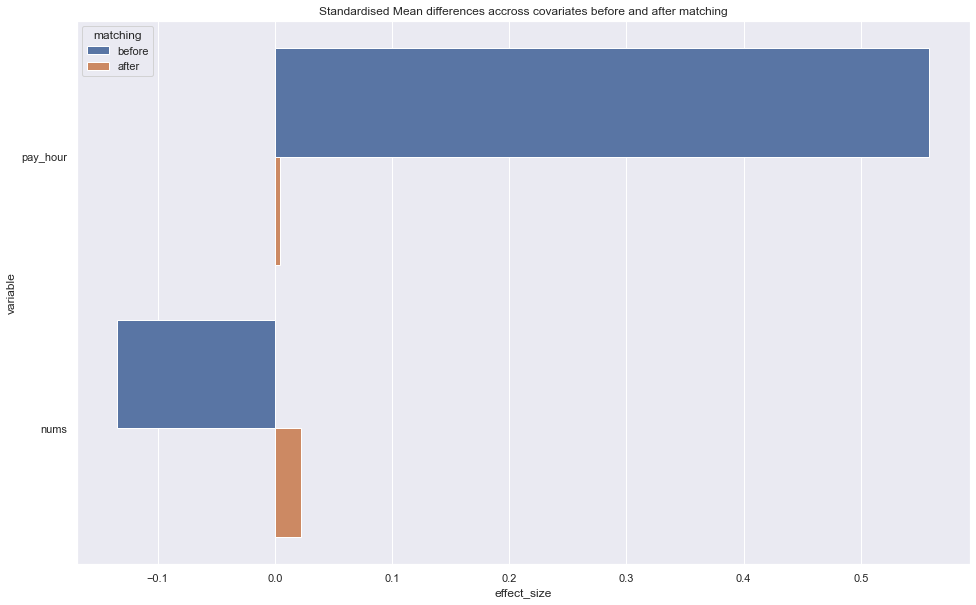

In [113]:
sn_plot = sns.barplot(data = res, y = 'variable', x = 'effect_size', hue = 'matching', orient='h')
sn_plot.set(title='Standardised Mean differences accross covariates before and after matching')
sn_plot.figure.savefig("standardised_mean_differences.png")

### ***Average Treatement effect***

In [114]:
overview = all_mached_data[['outcome','treatment']].groupby(by = ['treatment']).aggregate([np.mean, np.var, np.std, 'count'])
print(overview)

            outcome                           
               mean       var       std  count
treatment                                     
0.0        0.314843  0.215723  0.464460  33712
1.0        0.120640  0.106089  0.325713  33712


In [115]:
treated_outcome = overview['outcome']['mean'][1]
treated_counterfactual_outcome = overview['outcome']['mean'][0]

In [116]:
att = treated_outcome - treated_counterfactual_outcome
print('The Average Treatment Effect (ATT): {:.4f}'.format(att))

The Average Treatment Effect (ATT): -0.1942
